<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1_P4_BO_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

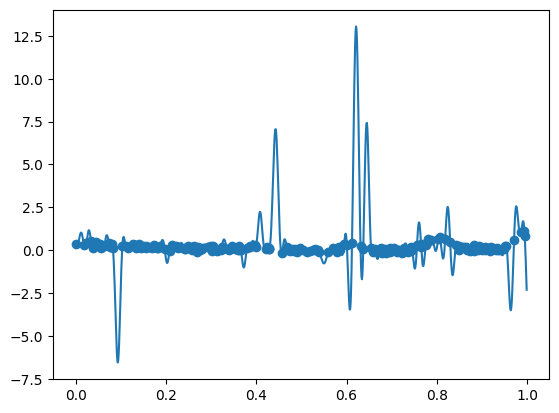

>x=0.086, f()=-1.661, actual=0.158
>x=0.962, f()=-3.325, actual=0.488
>x=0.979, f()=-3.271, actual=0.918
>x=0.632, f()=-1.186, actual=0.115
>x=0.609, f()=-1.330, actual=0.132
>x=0.620, f()=-1.655, actual=0.255
>x=0.998, f()=-2.044, actual=1.019
>x=0.834, f()=-1.449, actual=0.296
>x=0.202, f()=-0.728, actual=0.197
>x=0.372, f()=-0.991, actual=0.110
>x=0.411, f()=-1.546, actual=0.179
>x=0.751, f()=-1.059, actual=0.268
>x=0.543, f()=-0.209, actual=0.021
>x=0.723, f()=-0.208, actual=0.010
>x=0.507, f()=-0.242, actual=-0.196
>x=0.671, f()=-0.262, actual=-0.032
>x=0.563, f()=-0.354, actual=0.247
>x=0.554, f()=-0.791, actual=-0.096
>x=0.456, f()=-0.184, actual=0.103
>x=0.319, f()=-0.252, actual=-0.054
>x=0.509, f()=-0.182, actual=-0.021
>x=0.458, f()=-0.656, actual=-0.207
>x=0.405, f()=-0.127, actual=0.092
>x=0.559, f()=-0.191, actual=0.085
>x=0.944, f()=-0.141, actual=0.100
>x=0.457, f()=-0.254, actual=0.061
>x=0.459, f()=-0.120, actual=0.055
>x=0.605, f()=-0.135, actual=0.381
>x=0.508, f()=

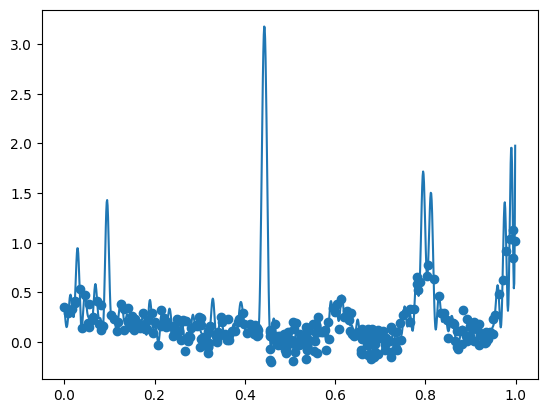

Best Result: x=0.458, y=-0.207


In [8]:
from math import sin, cos
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmin, argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return ((x-0.6) ** 2 + x ** 2 * cos(5 * pi * x) ** 6.0) + noise

# Surrogate function
def surrogate(model, X):
    with catch_warnings():
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# LCB (Lower Confidence Bound) acquisition function
def acquisition(X, Xsamples, model, kappa=1.96):
    mu, std = surrogate(model, Xsamples)
    scores = mu - kappa * std  # Lower confidence bound
    return scores

# Optimize the acquisition function
def opt_acquisition(X, y, model):
    Xsamples = random(100).reshape(-1, 1)
    scores = acquisition(X, Xsamples, model)
    ix = argmin(scores)  # Select the point with the lowest acquisition score
    return Xsamples[ix, 0]

# Plot function
def plot(X, y, model, img_name='plot'):
    pyplot.scatter(X, y)
    Xsamples = asarray(arange(0, 1, 0.001)).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.show()
    pyplot.close()

# Sample the domain sparsely with noise
X = random(200).reshape(-1, 1)
y = asarray([objective(x) for x in X]).reshape(-1, 1)

# Define the model
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-2, 10.0))
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=2)

# Fit the model using X, y
model.fit(X, y)

# Plot before optimization
plot(X, y, model, img_name='gp_initial_model')

# Perform the optimization process
for i in range(100):
    # Select the next point to sample
    x = opt_acquisition(X, y, model)
    # Sample the point
    actual = objective(x)
    # Summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%.3f, actual=%.3f' % (x, est[0], actual))
    # Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # Update the model
    model.fit(X, y)

# Plot final result
plot(X, y, model, img_name='gp_result_model')

# Best result
ix = argmin(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix].item(), y[ix].item()))